In [2]:
import cv2
import numpy as np
from pathlib import Path
from PIL import Image

In [3]:
dataset_path = "./datasets/raw/mvtec-ad"
damage_category = "transistor"
test_path = Path(dataset_path) / damage_category / "test"
gt_mask_path = Path(dataset_path) / damage_category / "ground_truth"

In [4]:
print(test_path.exists())
print(gt_mask_path.exists())

True
True


In [5]:
def get_connected_components(gt_mask_path):
    # mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    mask = Image.open(gt_mask_path)
    mask_array = np.array(mask)

    output = cv2.connectedComponentsWithStats(mask_array, 4, cv2.CV_32S)
    numLabels, labels, stats, centroids = output
    # exclude background (first box) and take only the bounding boxes
    boxes = stats[1:, :4]
    return boxes.tolist()  # x, y, w, h

In [6]:
# Sanity check

tmp = Path("/home/nisyad/projects/industrial-defect-detection/datasets/raw/mppd/metal_plate/ground_truth/total_rust/000_mask.png")
tmp2 = get_connected_components(tmp)
tmp2

[[147, 157, 707, 728]]

In [7]:
class_names = [entry.name for entry in test_path.iterdir() if entry.is_dir()]

print(len(class_names))
print(class_names)

5
['good', 'bent_lead', 'cut_lead', 'misplaced', 'damaged_case']


In [26]:
# Rephrase the class names

rephrased_class_names = {
    "good": ["good"],
    "brokem_or_misplaced_lead" : ["bent_lead", "cut_lead"],
    "misplaced transistor" :  ["misplaced"],
    "damaged casing": ["damaged_case"]
}

rephrased_class_names

{'good': ['good'],
 'brokem_or_misplaced_lead': ['bent_lead', 'cut_lead'],
 'misplaced transistor': ['misplaced'],
 'damaged casing': ['damaged_case']}

In [27]:
class_names_to_id = {class_name: i+1 for i,
                     class_name in enumerate(class_names)}
class_names_to_id

{'good': 1, 'bent_lead': 2, 'cut_lead': 3, 'misplaced': 4, 'damaged_case': 5}

In [28]:
rephrased_class_names_to_id = {rephrased_class_name: i+1 for i,
                               rephrased_class_name in enumerate(rephrased_class_names.keys())}

rephrased_class_names_to_id

{'good': 1,
 'brokem_or_misplaced_lead': 2,
 'misplaced transistor': 3,
 'damaged casing': 4}

In [29]:
damage_type_to_annotations = {}
file_name_to_boxes = {}

for class_name in class_names:
    if class_name == "good":
        continue

    class_path = gt_mask_path / class_name
    gt_mask_paths = [(entry.name, entry) for entry in class_path.iterdir()]
    for file_name, file_path in gt_mask_paths:
        file_name_to_boxes[file_name] = get_connected_components(file_path)

    damage_type_to_annotations[class_name] = file_name_to_boxes.copy()

In [30]:
print(len(damage_type_to_annotations.keys()))
damage_type_to_annotations


4


{'bent_lead': {'005_mask.png': [[101, 731, 230, 185]],
  '004_mask.png': [[460, 885, 62, 105]],
  '009_mask.png': [[706, 883, 66, 136], [230, 884, 69, 107]],
  '008_mask.png': [[368, 587, 191, 359]],
  '003_mask.png': [[503, 741, 111, 150]],
  '002_mask.png': [[204, 742, 107, 180]],
  '001_mask.png': [[701, 834, 45, 62]],
  '007_mask.png': [[487, 625, 292, 318]],
  '006_mask.png': [[245, 665, 392, 359]],
  '000_mask.png': [[239, 829, 51, 118]]},
 'cut_lead': {'005_mask.png': [[679, 727, 100, 180]],
  '004_mask.png': [[608, 615, 174, 280], [467, 624, 92, 273]],
  '009_mask.png': [[470, 587, 106, 306]],
  '008_mask.png': [[597, 602, 178, 300]],
  '003_mask.png': [[233, 667, 153, 245]],
  '002_mask.png': [[462, 730, 93, 159]],
  '001_mask.png': [[615, 695, 175, 228]],
  '007_mask.png': [[242, 741, 139, 148]],
  '006_mask.png': [[226, 714, 184, 203]],
  '000_mask.png': [[234, 785, 140, 156]]},
 'misplaced': {'005_mask.png': [[226, 79, 750, 826]],
  '004_mask.png': [[238, 77, 555, 816]],
  

In [31]:
import os

import PIL.Image as Image

images = []

id = 0
for root, dirs, files in os.walk(test_path):
    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(root, file)
            image = Image.open(file_path)
            width, height = image.size

            relative_file_path = os.path.relpath(file_path, test_path)

            id += 1
            single_image = {
                "id": id,
                "width": width,
                "height": height,
                "file_name": "test/" + relative_file_path,
                "zip_file": "test.zip"
            }

            images.append(single_image.copy())

print(len(images))
print(images[0])
print(images[-1])

100
{'id': 1, 'width': 1024, 'height': 1024, 'file_name': 'test/good/035.png', 'zip_file': 'test.zip'}
{'id': 100, 'width': 1024, 'height': 1024, 'file_name': 'test/damaged_case/002.png', 'zip_file': 'test.zip'}


In [32]:
def get_rephrased_class_id(rephrased_class_names_to_id, class_name):
    
    for rephrased_class_name, class_names in rephrased_class_names.items():
        if class_name in class_names:
            return rephrased_class_names_to_id[rephrased_class_name]
        
    

In [33]:
annotations = []

id = 0
for image in images:
    _, damage_type, img_name = image['file_name'].split("/")

    if damage_type == "good":
        continue

    image_name = img_name.split(".")[0]
    mask_name = f"{image_name}_mask.png"

    for bbox in damage_type_to_annotations[damage_type][mask_name]:
        id += 1
        single_annotation = {
            "id": id,
            "category_id": get_rephrased_class_id(rephrased_class_names_to_id, damage_type),
            "image_id": image['id'],
            "bbox": bbox
        }

        annotations.append(single_annotation.copy())

print(len(annotations))
print(annotations[0])
print(annotations[-1])

44
{'id': 1, 'category_id': 2, 'image_id': 61, 'bbox': [503, 741, 111, 150]}
{'id': 44, 'category_id': 4, 'image_id': 100, 'bbox': [318, 311, 88, 109]}


In [35]:
# Sanity check - check if any category_id is None

for annotation in annotations:
    assert annotation['category_id'] is not None

In [36]:
categories = []

for class_name, class_id in rephrased_class_names_to_id.items():
    category = {
        "id": class_id,
        "name": class_name}
    categories.append(category.copy())

categories

[{'id': 1, 'name': 'good'},
 {'id': 2, 'name': 'brokem_or_misplaced_lead'},
 {'id': 3, 'name': 'misplaced transistor'},
 {'id': 4, 'name': 'damaged casing'}]

In [37]:
import json
coco_json = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}


with open(f"test.json", "w") as f:
    json.dump(coco_json, f)

In [ ]:
import PIL.Image as Image
import numpy as np

img_path = "datasets/raw/mvtec-ad/transistor/ground_truth/bent_lead/004_mask.png"

# thresh = Image.open("000_mask.png")
thresh = Image.open(img_path)
thresh

In [ ]:
thresh = np.array(thresh)
thresh.shape

In [ ]:
import cv2

output = cv2.connectedComponentsWithStats(
    thresh, 4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

In [ ]:
stats

In [ ]:
import cv2

import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(img_path)

i = 1
# Define the bounding box coordinates
x, y, w, h = stats[i][0], stats[i][1], stats[i][2], stats[i][3]

# Draw the bounding box on the image
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding box
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
from utils import load_local_vision_dataset, TorchDataset
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose

dataset = load_local_vision_dataset(dataset_name="mvtec_ad",
                                    dataset_config_path="./datasets.json",
                                    root_dir="./",
                                    task_type="object_detection",
                                    )


transform = Compose([ToTensor()])

dataset = TorchDataset(dataset, transform=None)
sample_img, sample_tgt = dataset[70]
print(sample_img)
print(sample_tgt)

In [ ]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
data_loader_context = DataLoader(dataset, batch_size=2, shuffle=True)

In [ ]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import matplotlib.patches as patches

to_pil = ToPILImage()
img = to_pil(sample_img.squeeze(0))

bbox_ltrb = sample_tgt.squeeze(0).tolist()[1:]


# Convert the bounding box coordinates from ltrb to xywh
x, y, x2, y2 = bbox_ltrb
w, h = x2 - x, y2 - y

# Convert relative coordinates to absolute coordinates
x, y, w, h = x * img.width, y * img.height, w * img.width, h * img.height


# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a rectangle patch
rect = patches.Rectangle((x, y), w, h, linewidth=2,
                         edgecolor='r', facecolor='none')

# Add the rectangle patch to the axes
ax.add_patch(rect)

# Show the image with the bounding box
plt.show()

In [ ]:
from mimetypes import guess_type
import io

buffer = io.BytesIO()
# You can change JPEG to PNG if you prefer
img.save(buffer, format="JPEG")

guess_type(buffer.getvalue())

In [ ]:
sample_tgt.squeeze(0).tolist()

In [ ]:
from utils import conert_tensor_to_base64

img_base64 = conert_tensor_to_base64(sample_img)
img_base64

In [45]:
from gpt_client import GPTClient
from dotenv import load_dotenv
import os

load_dotenv()

gpt_client = GPTClient(api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
                       api_key=os.getenv("AZURE_OPENAI_API_KEY"),
                       api_version="2023-12-01-preview",
                       deployment_name="gpt4o-001")

In [35]:
response = gpt_client.get_response("", "describe the image")
print(response)

BadRequestError: Error code: 400 - {'error': {'code': 'InvalidRequest', 'message': 'The deployed GPT model does not support Vision Enhancement and On Your Data (OYD) with images.'}}

In [46]:
from utils import convert_to_base64

base64_image, _ = convert_to_base64("./sample.png")
print(base64_image)

iVBORw0KGgoAAAANSUhEUgAABW8AAATACAYAAACPl7UKAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAGdYAABnWARjRyu0AAP+lSURBVHhe7P1pjy3bmqUJ+W7PufdGmxmVJFAfEP//H5RUVQiVVEggQEII8QEpUZFKKiEzIu69p9ltjWeM+ZrNZb7c9z4RAfIP41luy2bzdrOxaY0vX/7qq3gopZRSSimllFJKKaWU8qJ4vfallFJKKaWUUkoppZRSXhB9eFtKKaWUUkoppZRSSikvkD68LaWUUkoppZRSSimllBdIH96WUkoppZRSSimllFLKC6QPb0sppZRSSimllFJKKeUF0oe3pZRSSimllFJKKaWU8gLpw9tSSimllFJKKaWUUkp5gfThbSmllFJKKaWUUkoppbxA+vC2lFJKKaWUUkoppZRSXiB9eFtKKaWUUkoppZRSSikvkD68LaWUUkoppZRSSimllBdIH96WUkoppZRSSimllFLKC6QPb0sppZRSSimllFJKKeUF0oe3pZRSSimllFJKKaWU8gLpw9tSSimllFJKKaWUUkp5gfThbSmllFJKKaWUUkoppbxA+vC2lFJKKaWUUkoppZRSXiB9eFtKKaWUUkoppZRSSikvkD68LaWUUkoppZRSSimllBdIH96WUkoppZRSSimllFLKC6QPb0sppZRSSimllFJKKeUF0oe3pZRSSimllFJKKaWU8gLpw9tSSimllFJKKaWUUkp5gfThbSmllFJKKaWUUkoppbxA+vC2lFJKKaWUUkoppZRSXiB9eFtKKaWUUkoppZRSSikvkD68LaWUUkoppZRSSimllBdIH96WUkoppZRSSimllFLKC6QPb0sppZRSSimllFJKKeUF0oe3pZRSSimllFJKKaWU8gLpw9tSSimllFJKKaWUUkp5gfThbSmllFJKKaWUUkoppbxA+vC2lFJKKaWUUkoppZRSXiB9

In [47]:
gpt_client.get_response(base64_image, "use the image to tell a joke")

BadRequestError: Error code: 400 - {'error': {'code': 'InvalidRequest', 'message': 'The deployed GPT model does not support Vision Enhancement and On Your Data (OYD) with images.'}}

In [6]:
import requests
from PIL import Image

In [8]:
sample_img = Image.open("sample.png")
sample_img2 = Image.open("sample2.png")

In [12]:
sample_img_base64, _ = convert_to_base64("sample.png")
sample_img2_base64, _ = convert_to_base64("sample2.png")

{'messages': [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': [{'type': 'text', 'text': 'Describe the first and second images'}, {'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'image_url', 'image_url': {'url': ''}}]}], 'max_tokens': 200}

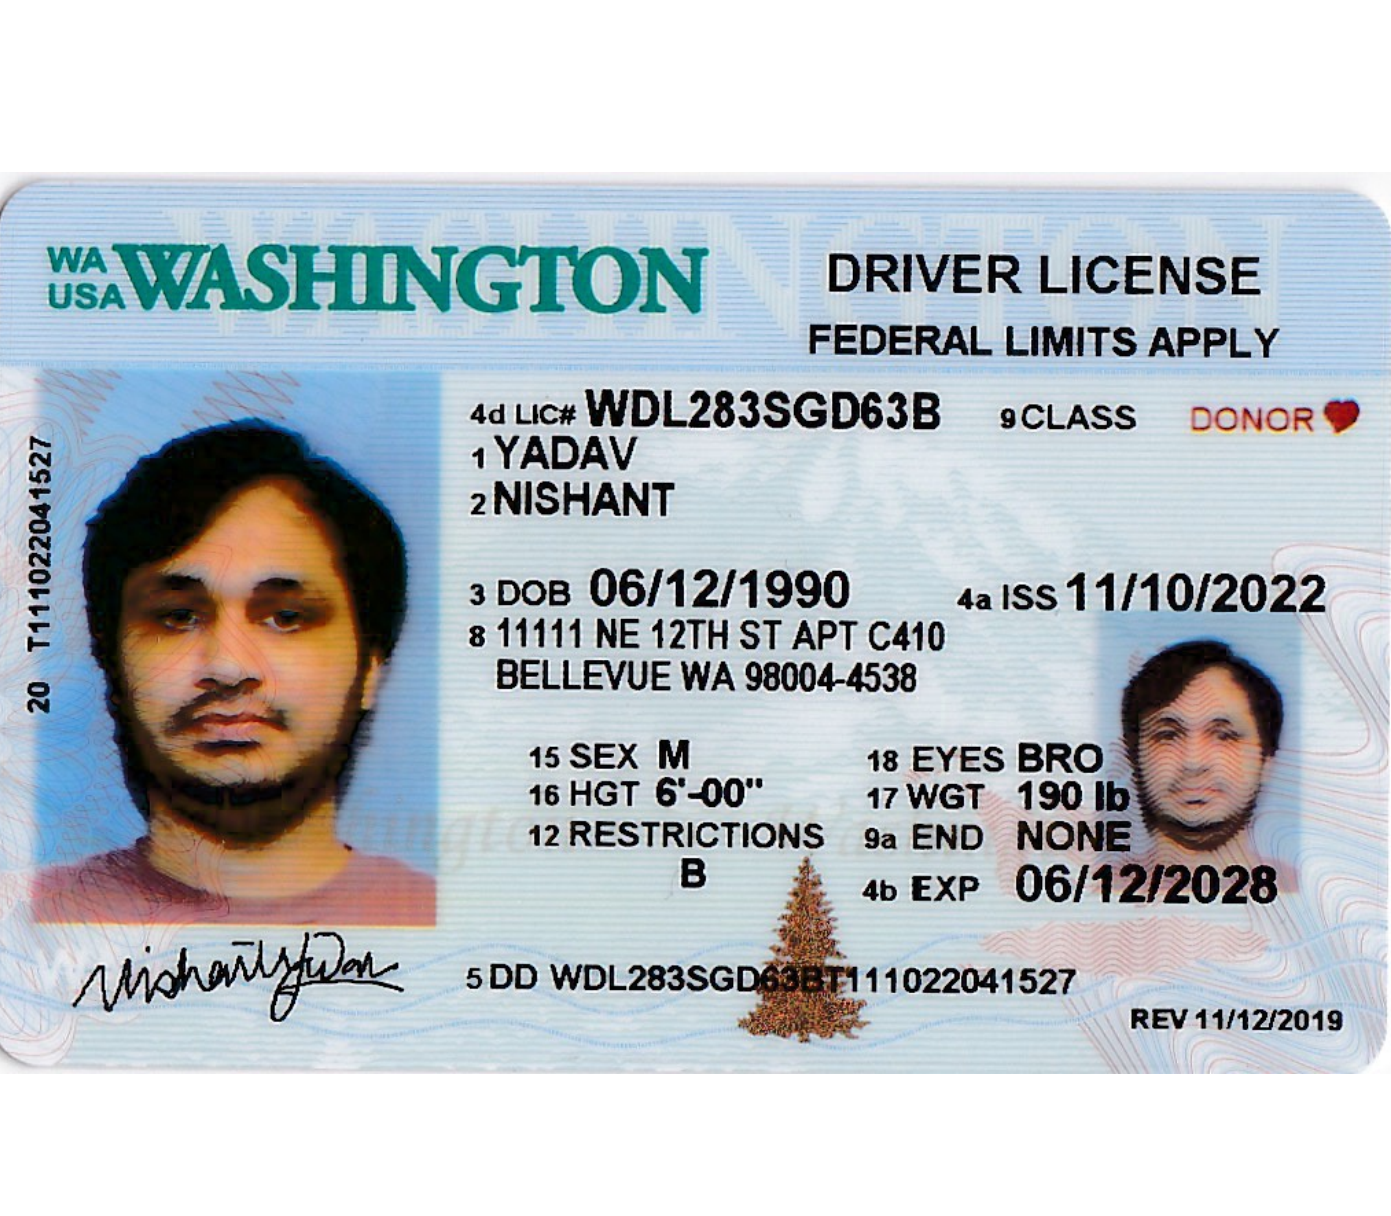
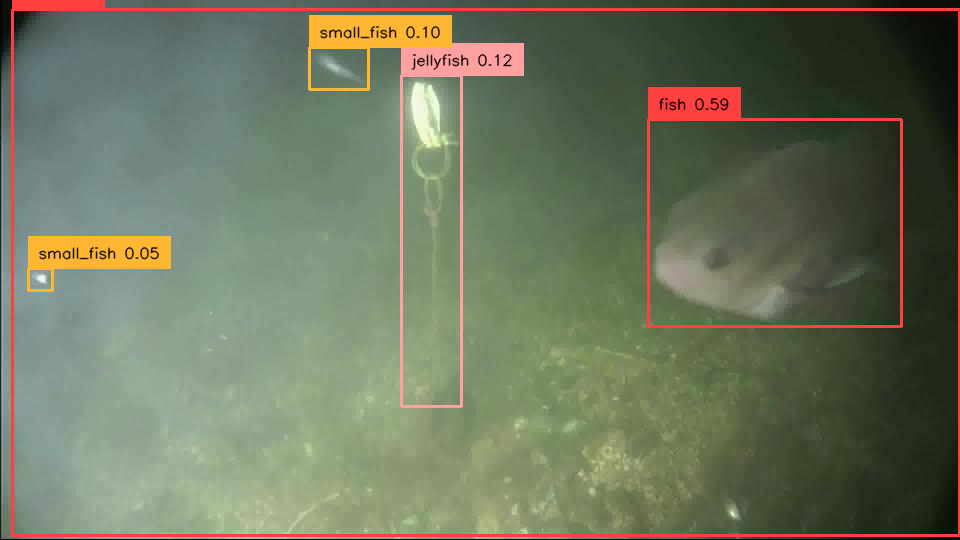

In [16]:
import json

request_body = {
    "messages": [
        {
            "role": "system",
            "content": "You are a helpful assistant."
        },
        {
            "role": "user",
            "content": [
                    {
                        "type": "text",
                        "text": "Describe the first and second images"
                    },
                {
                        "type": "image_url",
                        "image_url": {
                            "url": "data:image/png;base64," + sample_img_base64,
                        }
                    },
                {
                        "type": "image_url",
                        "image_url": {
                            "url": "data:image/png;base64," + sample_img2_base64,
                        }
                    }
            ]
        }
    ],
    "max_tokens": 200
}

print(request_body)

In [17]:
headers = {'api-key': os.getenv("AZURE_OPENAI_API_KEY"), 
           'Content-Type': 'application/json'}
endpoint = "https://customvision-dev-aoai.openai.azure.com"
deployment_name = "gpt4o-001"

url = f'{endpoint}/openai/deployments/{deployment_name}/chat/completions?api-version=2024-02-15-preview'


response = requests.post(url, headers=headers, json=request_body, timeout=120)

In [18]:
result = response.json()
result

{'choices': [{'content_filter_results': {'hate': {'filtered': False,
     'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'finish_reason': 'length',
   'index': 0,
   'logprobs': None,
   'message': {'content': '**First Image:**\nThe first image is a Washington state driver\'s license. Key details on the license include:\n- License number: WDL283SGD63B.\n- Name: Nishant Yadav.\n- Date of birth: June 12, 1990.\n- Address: 11111 NE 12th St, Apt C410, Bellevue, WA 98004-4538.\n- Sex: Male.\n- Height: 6\'0".\n- Weight: 190 lbs.\n- Eye color: Brown.\n- License class: D.\n- Restrictions: B.\n- Donor status: Yes (indicated by a heart symbol).\n- License issue date: November 10, 2022.\n- License expiration date: June 12, 2028.\n\n**Second Image:**\nThe second image is an underwater scene with multiple objects identified through an object detection s

In [ ]:
result.keys()

In [21]:
import json
import os
import requests
import torch
from dotenv import load_dotenv
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor

from utils import (
    TorchDataset,
    convert_tensor_to_base64,
    convert_to_base64,
    load_local_vision_dataset,
)

from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

In [25]:


token_provider = get_bearer_token_provider(

        DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"

    )



client = AzureOpenAI(

    api_version="2024-02-15-preview",

    azure_endpoint="https://customvision-dev-aoai.openai.azure.com/",

    azure_ad_token_provider=token_provider

)



response = client.chat.completions.create(

        model="gpt4o-001",

       messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": [
                        {
                            "type": "text",
                            "text": f"tell me a joke in json format"
                        }
                    ]}
                ],

        response_format={"type": "json_object"}, #enforce json o/p

    )

 

In [26]:
response

ChatCompletion(id='chatcmpl-9jCz3ulqGve5xbGEXHcUOhSU87RYl', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "setup": "Why don\'t scientists trust atoms?",\n  "punchline": "Because they make up everything!"\n}', role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1720561697, model='gpt-4o-2024-05-13', object='chat.completion', service_tier=None, system_fingerprint='fp_abc28019ad', usage=CompletionUsage(completion_tokens=26, prompt_tokens=24, total_tokens=50), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence